In [1]:
from datasets import load_dataset
dataset = load_dataset("mohammad2928git/complete_medical_symptom_dataset")

/Users/namratatanwani/llm-finetuning/env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/namratatanwani/llm-finetuning/env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import pandas as pd

In [3]:
df = dataset["train"].to_pandas()[['text','label', 'lebel_text']]
df.dropna(inplace=True)
frequent_labels = df["lebel_text"].value_counts()
frequent_labels = frequent_labels[frequent_labels > 1].index
df = df[df["lebel_text"].isin(frequent_labels)]
df.reset_index(inplace=True, drop=True)
df["clean_label"] = df["lebel_text"].apply(lambda x: x[0])

In [4]:
df

,text,label,lebel_text,clean_label
0,I have been having migraines and headaches. I ...,308.0,[drug reaction],drug reaction
1,I have asthma and I get wheezing and breathing...,35.0,[allergy],allergy
2,"cough,high_fever,breathlessness,family_history...",149.0,[bronchial asthma],bronchial asthma
3,"chills,vomiting,high_fever,sweating,headache,n...",596.0,[malaria],malaria
4,"I've been having back pain, a cough, and numbn...",186.0,[cervical spondylosis],cervical spondylosis
...,...,...,...,...
6001,"vomiting,headache,weakness_of_one_body_side,al...",718.0,[paralysis (brain hemorrhage)],paralysis (brain hemorrhage)
6002,"itching,skin_rash,stomach_pain,burning_micturi...",308.0,[drug reaction],drug reaction
6003,"muscle_wasting,high_fever,extra_marital_contacts",27.0,[aids],aids
6004,"vomiting,indigestion,loss_of_appetite,abdomina...",735.0,[peptic ulcer diseae],peptic ulcer diseae


In [5]:
from sklearn.model_selection import train_test_split
label_column = "clean_label"
X = df["text"]
y = df[label_column]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=41,
    stratify=y  
)

In [6]:
X_train

5191    joint_pain,vomiting,fatigue,yellowish_skin,dar...
4398    vomiting,headache,nausea,spinning_movements,lo...
5415    joint_pain,vomiting,fatigue,yellowish_skin,dar...
3341    I've been having trouble sleeping because of t...
3319    My legs have been swollen for a few days. I ca...
                              ...                        
3130    chills,vomiting,high_fever,sweating,headache,n...
4858    stomach_pain,acidity,ulcers_on_tongue,vomiting...
3560    skin_rash,chills,joint_pain,vomiting,fatigue,h...
688     continuous_sneezing,chills,fatigue,cough,heada...
266     I have a fever and chills, and my whole body i...
Name: text, Length: 4804, dtype: object

In [7]:
print("X_train:",X_train)
print("Y_train", y_train)
print("X_test", X_test)
print("y_test", y_test)

X_train: 5191    joint_pain,vomiting,fatigue,yellowish_skin,dar...
4398    vomiting,headache,nausea,spinning_movements,lo...
5415    joint_pain,vomiting,fatigue,yellowish_skin,dar...
3341    I've been having trouble sleeping because of t...
3319    My legs have been swollen for a few days. I ca...
                              ...                        
3130    chills,vomiting,high_fever,sweating,headache,n...
4858    stomach_pain,acidity,ulcers_on_tongue,vomiting...
3560    skin_rash,chills,joint_pain,vomiting,fatigue,h...
688     continuous_sneezing,chills,fatigue,cough,heada...
266     I have a fever and chills, and my whole body i...
Name: text, Length: 4804, dtype: object
Y_train 5191                                hepatitis d
4398    (vertigo) paroymsal  positional vertigo
5415                                hepatitis e
3341                                  psoriasis
3319                             varicose veins
                         ...                   
3130             

In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)
from datasets import Dataset as HFDataset
import warnings
warnings.filterwarnings('ignore')

In [ ]:
MODEL_NAME = "distilbert-base-uncased"  
MAX_LENGTH = 512
BATCH_SIZE = 16
LEARNING_RATE = 2e-5
NUM_EPOCHS = 3

In [12]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [ ]:
class MedicalTextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts.iloc[idx])
        label = self.labels[idx]
        
        
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }


In [ ]:
def prepare_data(X_train, Y_train, X_test, y_test):
    """prepare and encode the data"""
    
    label_encoder = LabelEncoder()
    all_labels = pd.concat([Y_train, y_test])
    label_encoder.fit(all_labels)
    y_train_encoded = label_encoder.transform(Y_train)
    y_test_encoded = label_encoder.transform(y_test)
    
    print(f"Number of classes: {len(label_encoder.classes_)}")
    print(f"Training samples: {len(X_train)}")
    print(f"Test samples: {len(X_test)}")
    
    return y_train_encoded, y_test_encoded, label_encoder

def create_model_and_tokenizer(num_labels):
    """initialize tokenizer and model"""
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=num_labels,
        problem_type="single_label_classification"
    )
    return tokenizer, model

def compute_metrics(eval_pred):
    """compute metrics for evaluation"""
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    
    accuracy = accuracy_score(labels, predictions)
    return {'accuracy': accuracy}

In [ ]:
def train_model(X_train, Y_train, X_test, y_test):
    """Main training function"""
    y_train_encoded, y_test_encoded, label_encoder = prepare_data(X_train, Y_train, X_test, y_test)
    num_labels = len(label_encoder.classes_)
    
    tokenizer, model = create_model_and_tokenizer(num_labels)

    train_dataset = MedicalTextDataset(X_train, y_train_encoded, tokenizer, MAX_LENGTH)
    test_dataset = MedicalTextDataset(X_test, y_test_encoded, tokenizer, MAX_LENGTH)
    
    def dataset_to_hf(dataset):
        return HFDataset.from_dict({
            'input_ids': [dataset[i]['input_ids'] for i in range(len(dataset))],
            'attention_mask': [dataset[i]['attention_mask'] for i in range(len(dataset))],
            'labels': [dataset[i]['labels'] for i in range(len(dataset))]
        })
    
    train_hf_dataset = dataset_to_hf(train_dataset)
    test_hf_dataset = dataset_to_hf(test_dataset)
    
    training_args = TrainingArguments(
        output_dir='./medical_model_results',
        num_train_epochs=NUM_EPOCHS,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        warmup_steps=500,
        weight_decay=0.01,
        logging_dir='./logs',
        logging_steps=100,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="accuracy",
        learning_rate=LEARNING_RATE,
        save_total_limit=2,
        seed=42,
    )
    
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_hf_dataset,
        eval_dataset=test_hf_dataset,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
    )
    
    print("Starting training...")
    trainer.train()
    print("\nEvaluating on test set...")
    test_results = trainer.evaluate(test_hf_dataset)
    print(f"Test Accuracy: {test_results['eval_accuracy']:.4f}")
    predictions = trainer.predict(test_hf_dataset)
    y_pred = np.argmax(predictions.predictions, axis=1)
    y_test_original = label_encoder.inverse_transform(y_test_encoded)
    y_pred_original = label_encoder.inverse_transform(y_pred)
    print("\nClassification Report:")
    print(classification_report(y_test_original, y_pred_original, zero_division=0))

    model.save_pretrained('./fine_tuned_medical_model')
    tokenizer.save_pretrained('./fine_tuned_medical_model')

    import joblib
    joblib.dump(label_encoder, './fine_tuned_medical_model/label_encoder.pkl')
    
    return trainer, label_encoder, y_pred_original, y_test_original

def predict_new_text(text, model_path='./fine_tuned_medical_model'):
    """Function to predict on new text"""
    import joblib

    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForSequenceClassification.from_pretrained(model_path)
    label_encoder = joblib.load(f'{model_path}/label_encoder.pkl')
    
    model.eval()
    inputs = tokenizer(
        text,
        truncation=True,
        padding='max_length',
        max_length=MAX_LENGTH,
        return_tensors='pt'
    )

    with torch.no_grad():
        outputs = model(**inputs)
        predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
        predicted_class = torch.argmax(predictions, dim=-1).item()
        confidence = torch.max(predictions).item()
    
    predicted_label = label_encoder.inverse_transform([predicted_class])[0]
    
    return predicted_label, confidence


In [16]:
trainer, label_encoder, y_pred, y_test_orig = train_model(X_train, y_train, X_test, y_test)

Number of classes: 45
Training samples: 4804
Test samples: 1202


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting training...


Epoch,Training Loss,Validation Loss,Accuracy
1,2.944800,2.391499,0.862729
2,0.775100,0.482852,0.952579
3,0.287800,0.235694,0.965890



Evaluating on test set...


Test Accuracy: 0.9659

Classification Report:
                                         precision    recall  f1-score   support

(vertigo) paroymsal  positional vertigo       1.00      1.00      1.00        24
                                   acne       1.00      1.00      1.00        24
                                   aids       1.00      1.00      1.00        24
                    alcoholic hepatitis       1.00      1.00      1.00        24
                                allergy       0.81      1.00      0.89        34
                              arthritis       0.97      1.00      0.99        34
                       bronchial asthma       0.91      0.94      0.93        34
                   cervical spondylosis       0.97      1.00      0.99        35
                            chicken pox       1.00      0.91      0.95        34
                    chronic cholestasis       1.00      1.00      1.00        24
                            common cold       1.00      1.00  

In [19]:
df["clean_label"].unique()

array(['drug reaction', 'allergy', 'bronchial asthma', 'malaria',
       'cervical spondylosis', 'hepatitis c', 'osteoarthristis',
       'alcoholic hepatitis', 'hypoglycemia', 'hyperthyroidism',
       'hepatitis a', 'dengue', 'chronic cholestasis', 'arthritis',
       'peptic ulcer diseae', 'tuberculosis', 'heart attack',
       'common cold', 'impetigo', 'migraine', 'acne', 'chicken pox',
       'typhoid', 'gastroenteritis', 'hepatitis d', 'hypertension',
       'jaundice', 'aids', 'fungal infection',
       '(vertigo) paroymsal  positional vertigo',
       'paralysis (brain hemorrhage)', 'peptic ulcer disease', 'gerd',
       'urinary tract infection', 'hepatitis e', 'hepatitis b',
       'dimorphic hemmorhoids(piles)', 'pneumonia', 'psoriasis',
       'hypertension ', 'diabetes ', 'hypothyroidism', 'varicose veins',
       'gastroesophageal reflux disease', 'diabetes'], dtype=object)

## LLM 

In [77]:
prompt = """
TASK:
Categorise the given symptoms into one of these conditions: 
       'drug reaction', 'allergy', 'bronchial asthma', 'malaria',
       'cervical spondylosis', 'hepatitis c', 'osteoarthristis',
       'alcoholic hepatitis', 'hypoglycemia', 'hyperthyroidism',
       'hepatitis a', 'dengue', 'chronic cholestasis', 'arthritis',
       'peptic ulcer diseae', 'tuberculosis', 'heart attack',
       'common cold', 'impetigo', 'migraine', 'acne', 'chicken pox',
       'typhoid', 'gastroenteritis', 'hepatitis d', 'hypertension',
       'jaundice', 'aids', 'fungal infection',
       '(vertigo) paroymsal  positional vertigo',
       'paralysis (brain hemorrhage)', 'peptic ulcer disease', 'gerd',
       'urinary tract infection', 'hepatitis e', 'hepatitis b',
       'dimorphic hemmorhoids(piles)', 'pneumonia', 'psoriasis',
       'hypertension ', 'diabetes ', 'hypothyroidism', 'varicose veins',
       'gastroesophageal reflux disease', 'diabetes'

INSTRUCTIONS:
1. Read the scenario carefully.
2. Identify the symptoms.
3. Strictly only output the condition from the given list.
4. Select the condition from the list as it is. No changes or extra characters.

OUTPUT FORMAT:
Reasoning: {You think about the symptoms and what is the condition}
Condition: {Mention the condition from the list}

SYMPTOMS:
"""

In [78]:
from openai import OpenAI
import os
from dotenv import load_dotenv
load_dotenv(override=True)

True

In [79]:
openai_key = os.getenv("OPENAI_KEY")

In [80]:
def get_gpt_response(prompt, context):
    client = OpenAI(
    api_key=openai_key  
)
    response = client.chat.completions.create(
                    
                    messages=[
                    {"role": "system", "content": prompt},
                    {"role": "user", "content": context},
                    ],
                    temperature=0,
                    model="gpt-4.1", 
                    seed=48,
                    max_tokens=5000
                )

    return response.choices[0].message.content


In [ ]:
all_results = []
all_symptoms = []
for context in X_train.values:
    # model = "gpt-4.1"
    result = get_gpt_response(prompt, context)
    # print(prompt + context)
    print(result)
    all_results.append(result)
    all_symptoms.append(context)

    d = {
        "text": all_symptoms,
        "generation": all_results
    }
    
    df_gpt_train = pd.DataFrame(d)
    df_gpt_train.to_csv("gpt4_1_prediction_train.csv", encoding="utf-8-sig", index=False)
    

Reasoning: The symptoms include persistent tiredness (fatigue), bad taste in the mouth, itchy throat, muscle pain and heat, and occasional whole-body cramps. These symptoms are non-specific but suggest a systemic condition. Fatigue and muscle pain can be seen in many conditions, but the combination of bad taste in the mouth, itchy throat, and muscle symptoms could point towards a viral infection or a metabolic/endocrine disorder. However, the presence of muscle cramps and generalized symptoms is most consistent with "hypothyroidism" from the list, as hypothyroidism can cause fatigue, muscle pain, cramps, and sometimes changes in taste or throat discomfort due to goiter.

Condition: hypothyroidism
Reasoning: The symptoms include fatigue, weight gain, cold hands and feet, mood swings, lethargy, dizziness, puffy face and eyes, enlarged thyroid, brittle nails, swollen extremities, depression, irritability, and abnormal menstruation. These are classic signs of an underactive thyroid gland, 

In [89]:
all_results = []
all_symptoms = []
for context in X_test.values:
    # model = "gpt-4.1"
    result = get_gpt_response(prompt, context)
    # print(prompt + context)
    print(result)
    all_results.append(result)
    all_symptoms.append(context)

    d = {
        "text": all_symptoms,
        "generation": all_results
    }
    
    df_gpt_train = pd.DataFrame(d)
    df_gpt_train.to_csv("gpt4_1_prediction_test.csv", encoding="utf-8-sig", index=False)

    

Reasoning: The symptoms include itching, vomiting, yellowish skin, loss of appetite, abdominal pain, and yellowing of eyes. These are classic signs of jaundice, which is often associated with liver conditions such as hepatitis. The presence of yellowish skin and eyes (jaundice), along with abdominal pain and loss of appetite, strongly suggests a liver-related disorder. Among the options, hepatitis a, hepatitis b, hepatitis c, hepatitis d, hepatitis e, and jaundice are possible. However, "jaundice" is the most direct match for these symptoms as it describes the syndrome itself.
Condition: jaundice
Reasoning: The presence of a rash with peeling skin suggests a skin-related issue, possibly an infection or immune-related. Increased susceptibility to illnesses points toward a compromised immune system. Shakiness and hand tremors could be due to metabolic or systemic issues. Among the options, "aids" is known for causing immunosuppression, making individuals more susceptible to infections, i

In [90]:
def clean_generation(text):
    return text.split("Condition:")[1].strip()

In [ ]:
y_train_pred_df = pd.read_csv("gpt4_1_prediction_train.csv")

y_test_pred_df = pd.read_csv("gpt4_1_prediction_test.csv")

In [92]:
y_train_pred_df["clean_generation"] = y_train_pred_df["generation"].apply(clean_generation)
y_test_pred_df["clean_generation"] = y_test_pred_df["generation"].apply(clean_generation)

In [93]:
from sklearn.metrics import accuracy_score, classification_report
print("GPT 4.1 Classification Results on Train Set")
print(classification_report(y_train, y_train_pred_df["clean_generation"], zero_division=0))

GPT 4.1 Classification Results on Train Set
                                         precision    recall  f1-score   support

(vertigo) paroymsal  positional vertigo       0.82      1.00      0.90        96
                                   acne       1.00      0.89      0.94        97
                                   aids       0.92      1.00      0.96        96
                    alcoholic hepatitis       1.00      1.00      1.00        97
                                allergy       0.18      0.14      0.16       136
                              arthritis       0.77      0.83      0.80       137
                       bronchial asthma       0.72      0.10      0.17       136
                   cervical spondylosis       0.91      0.99      0.95       136
                            chicken pox       0.93      0.76      0.84       136
                    chronic cholestasis       0.00      0.00      0.00        96
                            common cold       0.57      0.95    

In [94]:
from sklearn.metrics import accuracy_score, classification_report
print("GPT 4.1 Classification Results on Test Set")
print(classification_report(y_test, y_test_pred_df["clean_generation"], zero_division=0))

GPT 4.1 Classification Results on Test Set
                                         precision    recall  f1-score   support

(vertigo) paroymsal  positional vertigo       0.80      1.00      0.89        24
                                   acne       0.96      0.96      0.96        24
                                   aids       0.92      1.00      0.96        24
                    alcoholic hepatitis       1.00      1.00      1.00        24
                                allergy       0.12      0.06      0.08        34
                              arthritis       0.67      0.76      0.71        34
                       bronchial asthma       0.40      0.06      0.10        34
                   cervical spondylosis       0.80      0.94      0.87        35
                            chicken pox       0.90      0.82      0.86        34
                    chronic cholestasis       0.00      0.00      0.00        24
                            common cold       0.56      0.97     

In [ ]:
X_train["cl"]

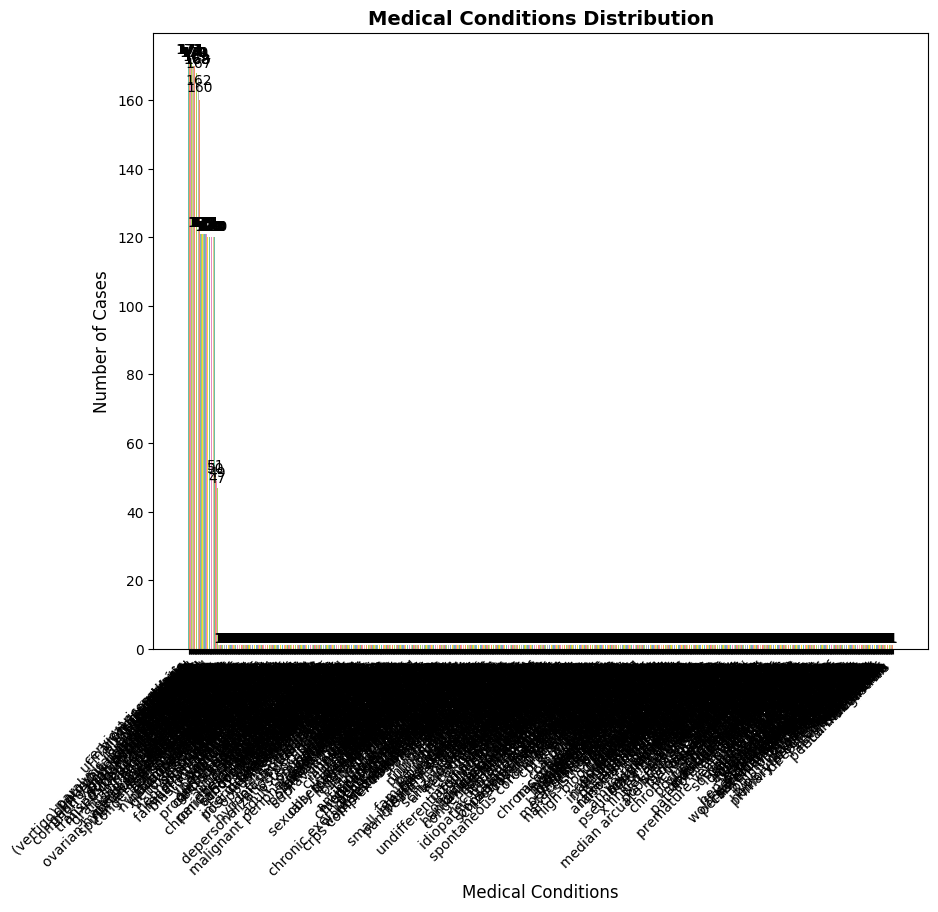

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
fig = plt.figure(figsize=(10, 8))

# 1. Vertical Bar Chart
# plt.subplot(100, 80, 1)
label_column = 'clean_text'
value_counts = df[label_column].value_counts()
total_samples = len(df)
colors = sns.color_palette("Set2", len(value_counts))
bars = plt.bar(range(len(value_counts)), value_counts.values, color=colors)
plt.title('Medical Conditions Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Medical Conditions', fontsize=12)
plt.ylabel('Number of Cases', fontsize=12)
plt.xticks(range(len(value_counts)), value_counts.index, rotation=45, ha='right')

# Add value labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
            f'{int(height)}', ha='center', va='bottom', fontsize=10)
